# Imports

In [73]:
import os, sys, time, json, csv, math, difflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tif
from scipy.ndimage.interpolation import zoom

sys.path.append("../../src")
from utils.atlases import reformat, replace_with_common_name, check_for_syn, get_parent_id_from_praid, get_hierarchy, get_dissimilarity

import warnings
warnings.simplefilter('ignore')

# User Inputs

In [120]:
# load label csvs 
labels_dir = '/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/'

# this is the file we want to relate to the PRA
lab_pma = pd.read_csv(os.path.join(labels_dir,'PMA_anns.csv'))
lab_sigma = pd.read_csv(os.path.join(labels_dir,'outdated/SIGMA_labels.csv'))
lab_schwarz = pd.read_csv(os.path.join(labels_dir,'outdated/schwarz_rl_annotations.csv'))
lab_whs = pd.read_csv(os.path.join(labels_dir,'outdated/WHS_labels.csv'))
lab_fisher = pd.read_csv(os.path.join(labels_dir,'outdated/fischer_with_parents.csv'))
lab_le = pd.read_csv(os.path.join(labels_dir,'outdated/le_with_parents.csv'))

# load PRA files
syns_location = os.path.join(labels_dir,'syns_with_parents.csv')
syns=pd.read_csv(syns_location)
PRAlabs = pd.read_csv(os.path.join(labels_dir,'PRA_labels.csv'))

# load json
#with open(os.path.join(labels_dir,'PRA_ontology.json')) as f:
# ontology = json.load(f)

# Example of how to take a labeled volume and relate to PRA

In [121]:
lab_atl = lab_le.copy()
savename='LE_in_PRA'

In [122]:
lab_atl=lab_atl.drop(columns=['Unnamed: 0','common_name','parent','pra_id'])
lab_atl.columns=['ID','abbr','label','notes']

In [123]:
lab_atl.insert(2,'common_name','null')
lab_atl.insert(2,'name','null')
lab_atl

,ID,abbr,name,common_name,label,notes
0,1,AID,null,null,"agranular insular cortex, dorsal part",valdes-hernandez
1,2,AIP,null,null,"agranular insular cortex, posterior part",valdes-hernandez
2,3,AIV,null,null,"agranular insular cortex, ventral part",valdes-hernandez
3,4,APir,null,null,amygdalopiriform transition area,valdes-hernandez
4,5,Au1,null,null,primary auditory cortex,valdes-hernandez
...,...,...,...,...,...,...
157,146,NaN,null,null,bed nucleus of the stria terminalis,calabrese
158,148,NaN,null,null,pituitary,calabrese
159,150,NaN,null,null,ventricles,calabrese
160,152,NaN,null,null,optic pathways,calabrese


In [124]:
syns=pd.read_csv(syns_location)
manual_check=[]
for i in lab_atl.index:
    lab_atl.at[i,'name']=reformat(str(lab_atl.label[i]))
    nm=lab_atl.at[i,'name']
    if nm in list(syns.common_name):
        #print('if')
        lab_atl.at[i,'common_name']=nm
    elif nm in list(syns.name):
        #print('elif')
        lab_atl.at[i,'common_name']=list(syns.common_name[syns.name==nm])[0]
    else:
        manual_check.append(i)

In [125]:
manual_check

[]

In [126]:
# for each element of manual_check, we print the name, and closest options
# add to syns csv, and re-import!
for idval in manual_check:
    print(list(lab_atl[lab_atl.index==idval]['name'])[0])
    print(difflib.get_close_matches(list(lab_atl[lab_atl.index==idval]['name'])[0],list(PRAlabs.name),n=20,cutoff=0.1))

In [127]:
# great! now we have common_names that match our PRA ID info. 
# Merge that info into your volume labels.
lab_atl=lab_atl.assign(praid=0,structure_id_path='0')
lab_atl

,ID,abbr,name,common_name,label,notes,praid,structure_id_path
0,1,AID,agranular_insular_cortex_dorsal_part,agranular_insular_cortex_dorsal,"agranular insular cortex, dorsal part",valdes-hernandez,0,0
1,2,AIP,agranular_insular_cortex_posterior_part,agranular_insular_cortex_posterior,"agranular insular cortex, posterior part",valdes-hernandez,0,0
2,3,AIV,agranular_insular_cortex_ventral_part,agranular_insular_cortex_ventral,"agranular insular cortex, ventral part",valdes-hernandez,0,0
3,4,APir,amygdalopiriform_transition_area,amygdalar_cortical_area_posterior_medial,amygdalopiriform transition area,valdes-hernandez,0,0
4,5,Au1,primary_auditory_cortex,primary_auditory_cortex,primary auditory cortex,valdes-hernandez,0,0
...,...,...,...,...,...,...,...,...
157,146,NaN,bed_nucleus_of_the_stria_terminalis,bed_nuclei_of_the_stria_terminalis,bed nucleus of the stria terminalis,calabrese,0,0
158,148,NaN,pituitary,pituitary,pituitary,calabrese,0,0
159,150,NaN,ventricles,ventricular_systems,ventricles,calabrese,0,0
160,152,NaN,optic_pathways,optic_pathways,optic pathways,calabrese,0,0


In [128]:
# id, family struct

for idx in lab_atl.index:
    atl_nm = lab_atl.common_name[idx]
    try:
        lab_atl.structure_id_path[idx] = PRAlabs[PRAlabs.name==atl_nm]['family_struct'].tolist()[0]
        lab_atl.praid[idx]=PRAlabs[PRAlabs.name==atl_nm]['id'].tolist()[0]
    except:
        print(atl_nm)

lab_atl

,ID,abbr,name,common_name,label,notes,praid,structure_id_path
0,1,AID,agranular_insular_cortex_dorsal_part,agranular_insular_cortex_dorsal,"agranular insular cortex, dorsal part",valdes-hernandez,618,/0/37/59/150/232/618
1,2,AIP,agranular_insular_cortex_posterior_part,agranular_insular_cortex_posterior,"agranular insular cortex, posterior part",valdes-hernandez,4,/0/37/59/150/232/4
2,3,AIV,agranular_insular_cortex_ventral_part,agranular_insular_cortex_ventral,"agranular insular cortex, ventral part",valdes-hernandez,619,/0/37/59/150/232/619
3,4,APir,amygdalopiriform_transition_area,amygdalar_cortical_area_posterior_medial,amygdalopiriform transition area,valdes-hernandez,344,/0/37/59/105/344
4,5,Au1,primary_auditory_cortex,primary_auditory_cortex,primary auditory cortex,valdes-hernandez,28,/0/37/59/233/28
...,...,...,...,...,...,...,...,...
157,146,NaN,bed_nucleus_of_the_stria_terminalis,bed_nuclei_of_the_stria_terminalis,bed nucleus of the stria terminalis,calabrese,368,/0/37/66/34/60/368
158,148,NaN,pituitary,pituitary,pituitary,calabrese,565,/0/37/565
159,150,NaN,ventricles,ventricular_systems,ventricles,calabrese,3,/0/3
160,152,NaN,optic_pathways,optic_pathways,optic pathways,calabrese,358,/0/2/157/121/358


In [129]:
lab_atl.to_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/{}.csv'.format(savename))

# random color thing, needs to be moved to cell plotting 

In [432]:
colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]

In [433]:
colors

[[255, 255, 255],
 [140, 78, 153],
 [111, 76, 155],
 [96, 89, 169],
 [85, 104, 184],
 [78, 121, 197],
 [77, 138, 198],
 [78, 150, 188],
 [84, 158, 179],
 [89, 165, 169],
 [96, 171, 158],
 [105, 177, 144],
 [119, 183, 125],
 [140, 188, 104],
 [166, 190, 84],
 [190, 188, 72],
 [209, 181, 65],
 [221, 170, 60],
 [228, 156, 57],
 [231, 140, 53],
 [230, 121, 50],
 [228, 99, 45],
 [223, 72, 40],
 [218, 34, 34],
 [255, 255, 255]]

In [435]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


from matplotlib.colors import ListedColormap

colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]
cell_rainbow = ListedColormap(np.divide(colors,255), name='cell_rainbow', N=None)
cell_rainbow

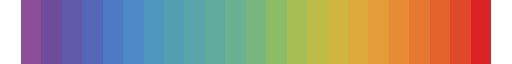